
# PHASE 1: COMPLETE ANN PROJECT FOR HOT DEFORMATION BEHAVIOR

# AISI 304 STAINLESS STEEL - FLOW STRESS PREDICTION

Project: Artificial Neural Network for Predicting Hot Deformation Behavior
Method: Multilayer Perceptron (MLP) with Backpropagation
Activation Functions: tanh (hidden) + linear (output)
Optimizer: Adam with Learning Rate = 0.01
Loss Function: Mean Squared Error (MSE)



In [67]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize, differential_evolution
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [68]:
# LOAD INPUT AND OUTPUT FILES SEPARATELY
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))  # Current working directory
data_dir = os.path.join(BASE_DIR, 'data', 'original_data')

# Define file names
input_file_name = 'Independent_variables.xlsx'
output_file_name = 'Response data.xlsx'

# Create SEPARATE file paths for each file
input_file_path = os.path.join(data_dir, input_file_name)
output_file_path = os.path.join(data_dir, output_file_name)

print("Using data directory:", data_dir)
print("Input file path:", input_file_path)
print("Output file path:", output_file_path)

Using data directory: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data
Input file path: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data/Independent_variables.xlsx
Output file path: /home/darlenewendie/PycharmProjects/ANN-Hot-workability-behaviour-of-AISI304-stainless-steel/data/original_data/Response data.xlsx


In [69]:
# LOAD BOTH FILES
print("\n" + "="*80)
print("LOADING DATA FILES")
print("="*80)

# Load input file (4 columns: T⁻¹, ln_SR, Strain, ε')
inputs_df = pd.read_excel(input_file_path)
print(f"\n✓ Input file loaded: {inputs_df.shape[0]} rows × {inputs_df.shape[1]} columns")
print(f"  Columns: {inputs_df.columns.tolist()}")

# Load output file (1 column: σ/σmax)
outputs_df = pd.read_excel(output_file_path)
print(f"\n✓ Output file loaded: {outputs_df.shape[0]} rows × {outputs_df.shape[1]} columns")
print(f"  Columns: {outputs_df.columns.tolist()}")


LOADING DATA FILES

✓ Input file loaded: 60 rows × 4 columns
  Columns: ['T⁻¹ (K⁻¹)', 'ln strain rate', 'Strain', 'ε͘΄']

✓ Output file loaded: 60 rows × 1 columns
  Columns: ['Output (σ/σmax)']


In [70]:
# VERIFY DATA INTEGRITY
print("\n" + "="*80)
print("DATA INTEGRITY CHECK")
print("="*80)

if len(inputs_df) != len(outputs_df):
    print(f"   WARNING: Row count mismatch!")
    print(f"   Input file: {len(inputs_df)} rows")
    print(f"   Output file: {len(outputs_df)} rows")
    raise ValueError("Input and output files must have the same number of rows!")
else:
    print(f"✓ Row count matches: {len(inputs_df)} rows in both files")


DATA INTEGRITY CHECK
✓ Row count matches: 60 rows in both files


In [71]:
# SELECT RELEVANT COLUMNS (Drop ε' - column 4)
print("\n" + "="*80)
print("SELECTING FEATURES")
print("="*80)

# Rename input columns for clarity
inputs_df.columns = ['T_inv', 'ln_Strain_Rate', 'Strain', 'epsilon_prime']

# Select only the 3 features we need (drop epsilon_prime)
inputs_selected = inputs_df[['T_inv', 'ln_Strain_Rate', 'Strain']].copy()

print("\n✓ Selected input features:")
print("  1. T_inv (Inverse Temperature)")
print("  2. ln_Strain_Rate (Log Strain Rate)")
print("  3. Strain (True Strain)")
print(f"\n Dropped: epsilon_prime (normalized strain rate - not needed)")

# Rename output column
outputs_df.columns = ['Stress_Normalized']


SELECTING FEATURES

✓ Selected input features:
  1. T_inv (Inverse Temperature)
  2. ln_Strain_Rate (Log Strain Rate)
  3. Strain (True Strain)

 Dropped: epsilon_prime (normalized strain rate - not needed)


In [72]:
# MERGE INPUT AND OUTPUT
print("\n" + "="*80)
print("MERGING DATA")
print("="*80)

# Merge side by side (axis=1 means column-wise)
df = pd.concat([inputs_selected, outputs_df], axis=1)

print(f"\n✓ Data merged successfully!")
print(f"  Final shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Columns: {df.columns.tolist()}")


MERGING DATA

✓ Data merged successfully!
  Final shape: 60 rows × 4 columns
  Columns: ['T_inv', 'ln_Strain_Rate', 'Strain', 'Stress_Normalized']


In [73]:
# DISPLAY DATA PREVIEW
print("\n" + "="*80)
print("DATA PREVIEW")
print("="*80)

print("\nFirst 10 rows:")
print(df.head(10))



DATA PREVIEW

First 10 rows:
      T_inv  ln_Strain_Rate  Strain  Stress_Normalized
0  0.000890       -2.302585     0.1           0.565722
1  0.000853       -2.302585     0.1           0.482011
2  0.000818       -2.302585     0.1           0.411714
3  0.000786       -2.302585     0.1           0.352587
4  0.000890        0.000000     0.1           0.690677
5  0.000853        0.000000     0.1           0.594937
6  0.000818        0.000000     0.1           0.513077
7  0.000786        0.000000     0.1           0.443056
8  0.000890        2.302585     0.1           0.825966
9  0.000853        2.302585     0.1           0.719375


In [74]:
# LAST 5 ROWS
print("\n" + "="*80)
print("LAST 5 ROWS")
print("="*80)
print(df.tail())


LAST 5 ROWS
       T_inv  ln_Strain_Rate  Strain  Stress_Normalized
55  0.000786        0.000000     0.5           0.556418
56  0.000890        2.302585     0.5           0.987976
57  0.000853        2.302585     0.5           0.867193
58  0.000818        2.302585     0.5           0.761909
59  0.000786        2.302585     0.5           0.669971


In [75]:
# DATA TYPES
print("\n" + "="*80)
print("DATA TYPES")
print("="*80)
print(df.dtypes)



DATA TYPES
T_inv                float64
ln_Strain_Rate       float64
Strain               float64
Stress_Normalized    float64
dtype: object


In [76]:
print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)
print(df.describe())


BASIC STATISTICS
           T_inv  ln_Strain_Rate     Strain  Stress_Normalized
count  60.000000    6.000000e+01  60.000000          60.000000
mean    0.000837    5.921189e-17   0.300000           0.663683
std     0.000039    1.895919e+00   0.142615           0.156613
min     0.000786   -2.302585e+00   0.100000           0.352587
25%     0.000810   -2.302585e+00   0.200000           0.553875
50%     0.000835    0.000000e+00   0.300000           0.652291
75%     0.000862    2.302585e+00   0.400000           0.762793
max     0.000890    2.302585e+00   0.500000           1.000000


In [77]:
# Reverse engineer for understanding
df['Temperature_K'] = 1 / df['T_inv']
df['Temperature_C'] = df['Temperature_K'] - 273.15
df['Strain_Rate'] = np.exp(df['ln_Strain_Rate'])

print(f"\nTest Conditions:")
print(f"Temperatures: {sorted(df['Temperature_C'].unique())} °C")
print(f"Strain Rates: {sorted(df['Strain_Rate'].unique())} s⁻¹")
print(f"Strains: {sorted(df['Strain'].unique())}")
df.head(10)


Test Conditions:
Temperatures: [np.float64(849.8499999999998), np.float64(849.85), np.float64(899.85), np.float64(949.85), np.float64(999.85)] °C
Strain Rates: [np.float64(0.09999999999999958), np.float64(0.10000000000000002), np.float64(1.0), np.float64(10.000000000000002)] s⁻¹
Strains: [np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5)]


,T_inv,ln_Strain_Rate,Strain,Stress_Normalized,Temperature_K,Temperature_C,Strain_Rate
0,0.000890,-2.302585,0.1,0.565722,1123.0,849.85,0.1
1,0.000853,-2.302585,0.1,0.482011,1173.0,899.85,0.1
2,0.000818,-2.302585,0.1,0.411714,1223.0,949.85,0.1
3,0.000786,-2.302585,0.1,0.352587,1273.0,999.85,0.1
4,0.000890,0.000000,0.1,0.690677,1123.0,849.85,1.0
5,0.000853,0.000000,0.1,0.594937,1173.0,899.85,1.0
6,0.000818,0.000000,0.1,0.513077,1223.0,949.85,1.0
7,0.000786,0.000000,0.1,0.443056,1273.0,999.85,1.0
8,0.000890,2.302585,0.1,0.825966,1123.0,849.85,10.0
9,0.000853,2.302585,0.1,0.719375,1173.0,899.85,10.0


In [78]:
# CHECK FOR MISSING VALUES
print("\n" + "="*80)
print("DATA QUALITY CHECK")
print("="*80)

missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    print(f"  Missing values detected:")
    print(missing[missing > 0])

duplicates = df.duplicated().sum()
if duplicates == 0:
    print("✓ No duplicate rows found!")
else:
    print(f"  {duplicates} duplicate rows found")


DATA QUALITY CHECK
✓ No missing values found!
✓ No duplicate rows found!


In [79]:
# CORRELATION
print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
corr = df[['T_inv', 'ln_Strain_Rate', 'Strain',  'Stress_Normalized']].corr()
print(corr)


CORRELATION MATRIX
                          T_inv  ln_Strain_Rate        Strain  \
T_inv              1.000000e+00   -2.149950e-16 -5.869395e-16   
ln_Strain_Rate    -2.149950e-16    1.000000e+00  3.479717e-17   
Strain            -5.869395e-16    3.479717e-17  1.000000e+00   
Stress_Normalized  6.680138e-01    6.567996e-01  2.743807e-01   

                   Stress_Normalized  
T_inv                       0.668014  
ln_Strain_Rate              0.656800  
Strain                      0.274381  
Stress_Normalized           1.000000  



CREATING VISUALIZATIONS...
✓ Saved: EDA_Quick.png


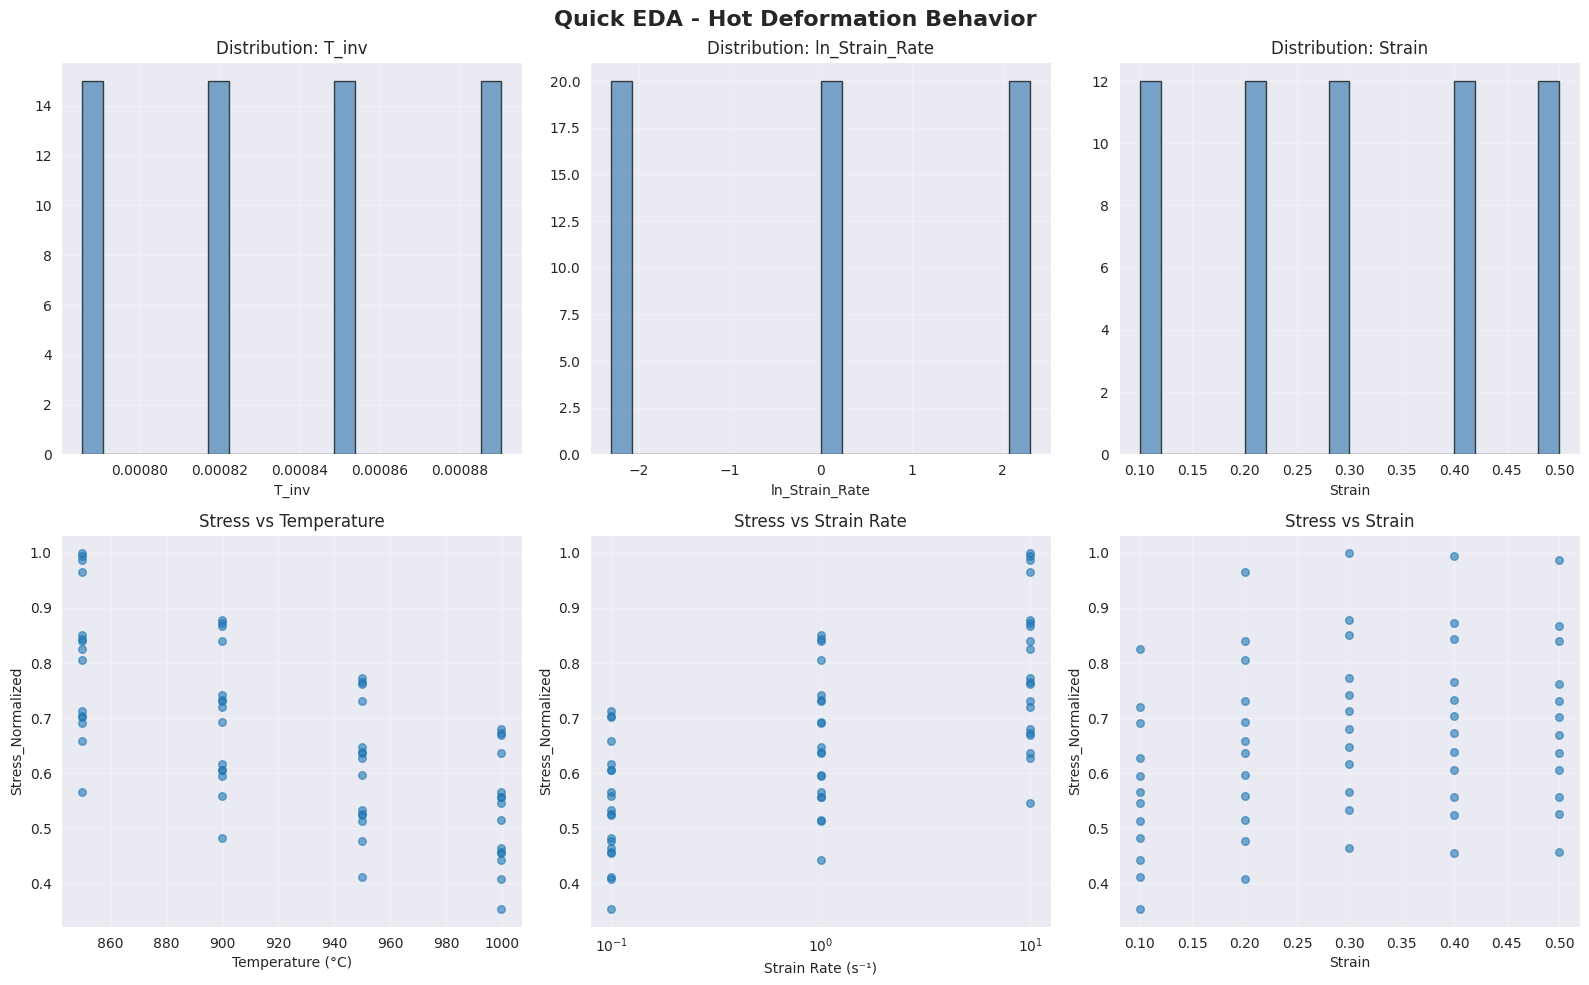

In [81]:
# VISUALIZATIONS
print("\n" + "="*80)
print("CREATING VISUALIZATIONS...")
print("="*80)

# Quick plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Quick EDA - Hot Deformation Behavior', fontsize=16, fontweight='bold')

# Distributions
for idx, col in enumerate(['T_inv', 'ln_Strain_Rate', 'Strain']):
    axes[0, idx].hist(df[col], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, idx].set_title(f'Distribution: {col}')
    axes[0, idx].set_xlabel(col)
    axes[0, idx].grid(True, alpha=0.3)

# Relationships with output
axes[1, 0].scatter(df['Temperature_C'], df['Stress_Normalized'], alpha=0.6, s=30)
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('Stress_Normalized')
axes[1, 0].set_title('Stress vs Temperature')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['Strain_Rate'], df['Stress_Normalized'], alpha=0.6, s=30)
axes[1, 1].set_xlabel('Strain Rate (s⁻¹)')
axes[1, 1].set_ylabel('Stress_Normalized')
axes[1, 1].set_xscale('log')
axes[1, 1].set_title('Stress vs Strain Rate')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].scatter(df['Strain'], df['Stress_Normalized'], alpha=0.6, s=30)
axes[1, 2].set_xlabel('Strain')
axes[1, 2].set_ylabel('Stress_Normalized')
axes[1, 2].set_title('Stress vs Strain')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('EDA_Quick.png', dpi=300, bbox_inches='tight')
print("✓ Saved: EDA_Quick.png")
plt.show()

✓ Saved: EDA_Correlation.png


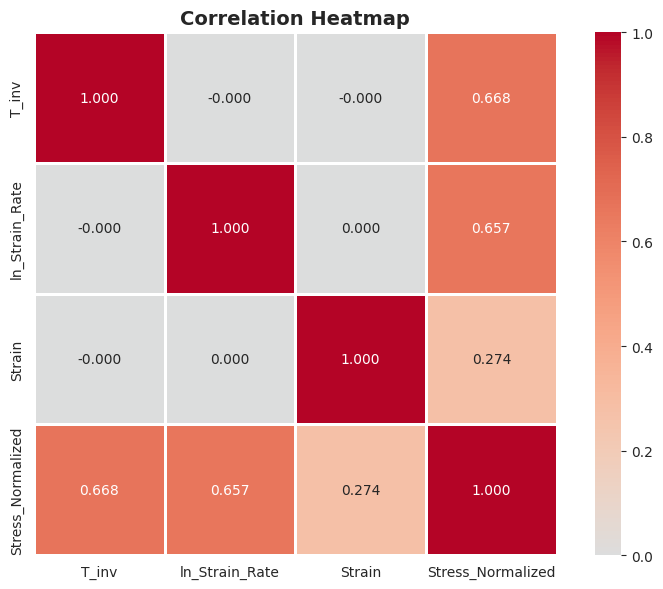


✓ EDA COMPLETE - READY FOR MODEL TRAINING!


In [82]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('EDA_Correlation.png', dpi=300, bbox_inches='tight')
print("✓ Saved: EDA_Correlation.png")
plt.show()

print("\n" + "="*80)
print("✓ EDA COMPLETE - READY FOR MODEL TRAINING!")
print("="*80)

In [86]:
print("\n" + "="*80)
print("PREPARING DATA FOR MODELING")
print("="*80)
# Prepare data for modeling
X = df[['T_inv', 'ln_Strain_Rate', 'Strain']].values
y = df['Stress_Normalized'].values.reshape(-1, 1)

print(f"\nModel Inputs (X): {X.shape}")
print(f"Model Output (y): {y.shape}")
print("\nNext: Train-Test Split → Build ANN → Compare with Paper (R=0.998, AARE=1.96%)")


PREPARING DATA FOR MODELING

Model Inputs (X): (60, 3)
Model Output (y): (60, 1)

Next: Train-Test Split → Build ANN → Compare with Paper (R=0.998, AARE=1.96%)
